# **Installation**

In [1]:
import subprocess
subprocess.check_call(["pip", "install", "-q", "stable-baselines3", "gym", "matplotlib", "pyvirtualdisplay", "tqdm"])

0

# **Imports**

In [2]:
import os
import sys
import random
import time
from collections import deque
import numpy as np
import torch
import gym
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import BaseCallback
from tqdm import tqdm
from IPython import display


/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/util.py:55: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs; see https://jax.readthedocs.io/en/latest/aot.html. For example, replace xla_computation(f)(*xs) with jit(f).lower(*xs).compiler_ir('hlo'). See CHANGELOG.md for 0.4.30 for more examples.
  from jax import xla_computation as _xla_computation


# **Configuration**

In [3]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
print(f"PyTorch CUDA available: {torch.cuda.is_available()}")
print(f"GPU Device Name: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'No GPU'}")
MODEL_SAVE_PATH = "/kaggle/working/trained_model.zip"
LOG_DIR = "/kaggle/working/logs"
os.makedirs(LOG_DIR, exist_ok=True)


PyTorch CUDA available: True
GPU Device Name: Tesla T4


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# **Environment**

In [ ]:
class AdvancedNetworkEnv(gym.Env):
    def __init__(self) -> None:
        super().__init__()
        self.base_detection_probability: float = 0.4
        self.base_port_scan_threshold: int = 3
        self.packet_size_threshold: int = 1200
        self.common_ports: list = [80, 443, 8080, 22, 53]
        self.suspicious_ports: list = [4444, 31337, 6667]
        self.max_suspicion: int = 100
        self.packet_history: deque = deque(maxlen=10)
        self.port_history: deque = deque(maxlen=5)
        self.action_history: deque = deque(maxlen=50)
        self.episode_count: int = 0
        self.difficulty_stage: int = 0
        self.step_count: int = 0
        self.max_steps: int = 100  
        self.action_space = gym.spaces.Discrete(5)
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(16,), dtype=np.float32)
        self.seed(RANDOM_SEED)
        self.reset()

    def seed(self, seed: int = None) -> list:
        self.np_random, _ = gym.utils.seeding.np_random(seed)
        return [seed]

    def _adjust_difficulty(self) -> None:
        self.difficulty_stage = self.episode_count // 10
        self.detection_probability: float = min(self.base_detection_probability + 0.1 * self.difficulty_stage, 1.0)
        self.port_scan_threshold: int = max(self.base_port_scan_threshold - self.difficulty_stage, 1)

    def _reset_history(self) -> None:
        self.packet_history.clear()
        self.port_history.clear()
        self.action_history.clear()
        self.step_count = 0

    def reset(self) -> np.ndarray:
        self.episode_count += 1
        self._adjust_difficulty()
        self.suspicion_level: int = 0
        self.current_port: int = 80  # start with a common port
        self._reset_history()
        return self._get_observation()

    def step(self, action: int) -> tuple:
        self._take_action(action)
        if self.step_count >= self.max_steps - 1:
            detected, cause = False, "survived"
        else:
            detected, cause = self._check_detection()

        reward = self._calculate_reward(action, detected)
        self.suspicion_level = min(self.max_suspicion, self.suspicion_level)
        done: bool = detected or (self.step_count >= self.max_steps - 1)
        if (self.step_count >= self.max_steps - 1) and not detected:
            reward += 10  
        self.step_count += 1
        obs: np.ndarray = self._get_observation()
        info: dict = {"detection_cause": cause, "episode_reward": reward}
        return obs, reward, done, info

    def _take_action(self, action: int) -> None:
        self.action_history.append(action)
        # Action definitions:
        # 0: Send small packet, 1: Send large packet, 2: Delay, 3: Change port, 4: Stealth combo
        if action == 0:
            self._send_packet(200)
        elif action == 1:
            self._send_packet(1500)
        elif action == 2:
            self._delay()
        elif action == 3:
            self._change_port()
        elif action == 4:
            self._stealth_combo()

    def _send_packet(self, size: int) -> None:
        self.packet_history.append(size)

    def _delay(self) -> None:
        self.packet_history.append(0)

    def _change_port(self) -> None:
        available_ports = [p for p in self.common_ports if p != self.current_port]
        new_port: int = int(self.np_random.choice(available_ports))
        self.port_history.append(new_port)
        self.current_port = new_port

    def _stealth_combo(self) -> None:
        self._delay()
        self._send_packet(200)
        self._change_port()

    def _check_detection(self) -> tuple:
        if len(self.packet_history) >= 4 and np.sum(np.array(self.packet_history) > self.packet_size_threshold) >= 4:
            return True, 'packet_size'
        if len(self.port_history) >= 3 and len(set(self.port_history)) > (self.port_scan_threshold + 2):
            return True, 'port_scan'
        if self.current_port in self.suspicious_ports:
            if np.random.rand() < self.detection_probability:
                return True, 'suspicious_port'
        return False, 'none'

    def _calculate_reward(self, action: int, detected: bool) -> float:
        if detected:
            return -100 - ((self.max_steps - self.step_count) * 0.5)
        
        survival_bonus = 0.2
        reward: float = survival_bonus
        if self.current_port in self.common_ports:
            reward += 0.5
        if action == 3: 
            reward -= 0.5
        if len(set([int(a) for a in self.action_history])) > 2:
            reward += 0.2
        return reward

    def _get_observation(self) -> np.ndarray:
        packets = list(self.packet_history)
        if packets:
            pkt_mean = np.mean(packets) / 1500.0
            pkt_max = np.max(packets) / 1500.0
            large_count = np.sum(np.array(packets) > self.packet_size_threshold)
            frac_large = large_count / len(packets)
        else:
            pkt_mean, pkt_max, frac_large = 0.0, 0.0, 0.0

        port_list = list(self.port_history)
        unique_ports = len(set(port_list))
        unique_norm = unique_ports / (self.port_history.maxlen if self.port_history.maxlen > 0 else 1)
        time_norm = min(self.step_count / self.max_steps, 1.0)

        
        last_action = [0] * 5
        if self.action_history:
            last_act = int(self.action_history[-1])
            if 0 <= last_act < 5:
                last_action[last_act] = 1

        
        last_ports = list(self.port_history)[-4:]
        if len(last_ports) < 4:
            last_ports = [0] * (4 - len(last_ports)) + last_ports
        last_ports_norm = [p / 65535.0 for p in last_ports]

        obs = np.array([
            self.suspicion_level / self.max_suspicion,
            self.current_port / 65535.0,
            pkt_mean,
            pkt_max,
            frac_large,
            unique_norm,
            time_norm
        ] + last_action + last_ports_norm, dtype=np.float32)
        return obs

# **Training Callback**

In [5]:
class EnhancedTrainingCallback(BaseCallback):
    def __init__(self, check_freq: int = 1000, verbose: int = 1) -> None:
        super().__init__(verbose)
        self.check_freq: int = check_freq
        self.metrics: dict = {
            'rewards': [],
            'suspicions': [],
            'actions': [],
            'ports': [],
            'detection_causes': []
        }
        self.reset_episode_tracking()

    def reset_episode_tracking(self) -> None:
        self.episode_rewards: list = []
        self.episode_suspicion: int = 0
        self.episode_actions: list = []
        self.episode_ports: list = []
        self.episode_detection_cause: str = 'none'

    def _on_step(self) -> bool:
        try:
            env = self.model.get_env().envs[0]
            self.episode_suspicion = env.suspicion_level
            if env.action_history:
                self.episode_actions.append(int(env.action_history[-1]))
            if env.port_history:
                self.episode_ports.append(env.current_port)
            infos = self.locals.get('infos')
            if infos and len(infos) > 0:
                info = infos[0]
                if info.get('detection_cause', 'none') != 'none':
                    self.episode_detection_cause = info['detection_cause']
            rewards = self.locals.get('rewards')
            if rewards and len(rewards) > 0:
                step_reward = rewards[0]
                self.episode_rewards.append(step_reward)
            if self.locals.get('dones') and self.locals['dones'][0]:
                self._process_episode_end()
        except (AttributeError, IndexError) as e:
            print(f"Warning: Error tracking metrics: {e}")
        if self.n_calls % self.check_freq == 0:
            self._log_progress()
            self._update_tensorboard()
        return True

    def _process_episode_end(self) -> None:
        if self.episode_rewards:
            total_reward = sum(self.episode_rewards)
            self.metrics['rewards'].append(total_reward)
            self.metrics['suspicions'].append(self.episode_suspicion)
            self.metrics['actions'].append(self.episode_actions.copy())
            self.metrics['ports'].append(self.episode_ports.copy())
            self.metrics['detection_causes'].append(self.episode_detection_cause)
        self.reset_episode_tracking()

    def _on_rollout_end(self) -> None:
        if self.model.ep_info_buffer:
            for info in self.model.ep_info_buffer:
                if 'r' in info and info['r'] not in self.metrics['rewards']:
                    self.metrics['rewards'].append(info['r'])

    def _log_progress(self) -> None:
        print(f"\nStep {self.n_calls} Metrics:")
        avg_reward = np.mean(self.metrics['rewards'][-100:]) if self.metrics['rewards'] else 0.0
        print(f"Avg Reward: {avg_reward:.2f}")
        print(f"Total episodes recorded: {len(self.metrics['rewards'])}")
        if self.metrics['detection_causes']:
            detection_rate = sum(1 for c in self.metrics['detection_causes'] if c not in ['none', 'survived']) / max(1, len(self.metrics['detection_causes']))
            print(f"Detection Rate: {detection_rate:.1%}")
        else:
            print("Detection Rate: 0.0%")
        port_diversity = np.mean([len(set(p)) for p in self.metrics['ports']]) if self.metrics['ports'] else 0.0
        print(f"Port Diversity: {port_diversity:.1f} unique ports")

    def _update_tensorboard(self) -> None:
        if self.metrics['rewards']:
            self.logger.record("metrics/avg_reward", np.mean(self.metrics['rewards'][-100:]))
            self.logger.record("metrics/total_episodes", len(self.metrics['rewards']))
        else:
            self.logger.record("metrics/avg_reward", 0.0)
            self.logger.record("metrics/total_episodes", 0)
        if self.metrics['detection_causes']:
            detection_rate = sum(1 for c in self.metrics['detection_causes'] if c not in ['none', 'survived']) / max(1, len(self.metrics['detection_causes']))
            self.logger.record("metrics/detection_rate", detection_rate)
        else:
            self.logger.record("metrics/detection_rate", 0.0)
        if self.metrics['ports']:
            port_diversity = np.mean([len(set(p)) for p in self.metrics['ports']])
            self.logger.record("metrics/port_diversity", port_diversity)
        else:
            self.logger.record("metrics/port_diversity", 0.0)


# **Model Configuration**

In [6]:
def create_gpu_optimized_model(env: gym.Env) -> PPO:
    device = "cuda" if torch.cuda.is_available() else "cpu"
    return PPO(
        policy="MlpPolicy",
        env=env,
        device=device,
        verbose=1,
        n_steps=2048,
        batch_size=128,
        n_epochs=10,
        learning_rate=2.5e-4,
        clip_range=0.2,
        gamma=0.99,
        gae_lambda=0.95,
        ent_coef=0.02,
        vf_coef=0.7,
        tensorboard_log=LOG_DIR,
        seed=RANDOM_SEED,
        max_grad_norm=0.5
    )


# **Visualization**

In [ ]:
def plot_comprehensive_metrics(metrics: dict) -> None:
    plt.figure(figsize=(20, 12))
    
    plt.subplot(2, 3, 1)
    if metrics['rewards']:
        plt.plot(metrics['rewards'], color='navy', alpha=0.7)
    plt.title('Training Reward Progression')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.grid(alpha=0.2)
    
    plt.subplot(2, 3, 2)
    if metrics['suspicions']:
        plt.hist(metrics['suspicions'], bins=20, color='maroon', alpha=0.7)
    plt.title('Suspicion Level Distribution')
    plt.xlabel('Final Suspicion Level (%)')
    
    plt.subplot(2, 3, 3)
    if metrics['actions']:
        try:
            all_actions = np.concatenate(metrics['actions'])
            action_counts = np.bincount(all_actions.astype(int), minlength=5)
            plt.bar(['Small', 'Large', 'Delay', 'Port', 'Stealth'], action_counts,
                    color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
        except Exception as e:
            print(f"Error in action distribution plot: {e}")
    plt.title('Action Selection Distribution')
    
    plt.subplot(2, 3, 4)
    if metrics['detection_causes']:
        causes = {'PacketSize': 0, 'PortScan': 0, 'SuspiciousPort': 0, 'Survived': 0, 'None': 0}
        for cause in metrics['detection_causes']:
            if cause == 'packet_size':
                causes['PacketSize'] += 1
            elif cause == 'port_scan':
                causes['PortScan'] += 1
            elif cause == 'suspicious_port':
                causes['SuspiciousPort'] += 1
            elif cause == 'survived':
                causes['Survived'] += 1
            elif cause == 'none':
                causes['None'] += 1
        non_zero_causes = {k: v for k, v in causes.items() if v > 0}
        if non_zero_causes:
            plt.pie(non_zero_causes.values(), labels=non_zero_causes.keys(), autopct='%1.1f%%',
                    colors=['#2ca02c', '#d62728', '#9467bd', '#7f7f7f', '#ff7f0e'])
    plt.title('Detection Causes Breakdown')
    
    plt.subplot(2, 3, 5)
    if metrics['ports']:
        try:
            all_ports = np.concatenate([np.array(p, dtype=int) for p in metrics['ports']])
            unique_ports, counts = np.unique(all_ports, return_counts=True)
            plt.bar(unique_ports.astype(str), counts, color='teal')
        except Exception as e:
            print(f"Error in port usage plot: {e}")
    plt.title('Port Usage Frequency')
    plt.xticks(rotation=45)
    
    plt.subplot(2, 3, 6)
    if metrics['suspicions'] and metrics['rewards'] and len(metrics['suspicions']) == len(metrics['rewards']):
        scatter = plt.scatter(metrics['suspicions'], metrics['rewards'], alpha=0.5,
                              c=metrics['suspicions'], cmap='viridis')
        plt.colorbar(scatter, label='Suspicion Level')
    plt.xlabel('Suspicion Level')
    plt.ylabel('Episode Reward')
    plt.title('Reward vs Suspicion Correlation')
    
    plt.tight_layout()
    plt.show()

    print("\nGenerating comprehensive visualizations...")
    plot_comprehensive_metrics(callback.metrics)

class LiveTrainingDashboard:
    
    
    def __init__(self, model: PPO) -> None:
        self.model = model
        self.env = AdvancedNetworkEnv()
        self.obs = self.env.reset()  
        self.fig = plt.figure(figsize=(20, 10))
        self.episode_data = {
            "rewards": [], 
            "suspicions": [], 
            "actions": [], 
            "ports": [],
            "steps": [] 
        }
        self.update_interval = 5  
        self.episode_count = 0
        
    
        self.fig.clf()
        self.ax1 = plt.subplot(2, 2, 1)
        self.ax2 = plt.subplot(2, 2, 2)
        self.ax3 = plt.subplot(2, 2, 3)
        self.ax4 = plt.subplot(2, 2, 4)
        
        
        self.reward_line, = self.ax1.plot([], [], label='Reward', color='blue', linewidth=2)
        self.suspicion_line, = self.ax1.plot([], [], label='Suspicion', color='red', linewidth=2)
        self.ax1.set_title('Live Performance Metrics', fontsize=14, fontweight='bold')
        self.ax1.set_xlabel('Step', fontsize=12)
        self.ax1.set_ylabel('Value', fontsize=12)
        self.ax1.set_ylim(-10, 10)  
        self.ax1.legend(fontsize=10)
        self.ax1.grid(alpha=0.3)
        
        
        self.action_names = ['Small Packet', 'Large Packet', 'Delay', 'Change Port', 'Stealth Combo']
        self.action_bars = self.ax2.bar(self.action_names, [0, 0, 0, 0, 0],
                                    color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
        self.ax2.set_title('Action Selection Distribution', fontsize=14, fontweight='bold')
        self.ax2.set_ylabel('Count', fontsize=12)
        self.ax2.tick_params(axis='x', rotation=15)
        
        
        self.port_container = self.ax3
        self.ax3.set_title('Port Usage Frequency', fontsize=14, fontweight='bold')
        self.ax3.set_xlabel('Port Number', fontsize=12)
        self.ax3.set_ylabel('Frequency', fontsize=12)
        self.ax3.grid(alpha=0.3)
        
        
        self.status_text = self.ax4.text(0.5, 0.5, "OPERATIONAL\nEpisode: 0", 
                                     ha='center', va='center', fontsize=24, color='green')
        self.ax4.text(0.5, 0.8, "Agent Status", ha='center', va='center', 
                  fontsize=18, fontweight='bold')
        self.ax4.axis('off')
        
        plt.tight_layout()
        
        self.display_handle = display.display(self.fig, display_id="dashboard")
        plt.close()
    
    def update_dashboard(self, step: int) -> None:
        try:
            action, _ = self.model.predict(self.obs)
            if isinstance(action, np.ndarray):
                action = int(action)
            

            self.obs, reward, done, info = self.env.step(action)
            
            
            self.episode_data['rewards'].append(reward)
            self.episode_data['suspicions'].append(self.env.suspicion_level)
            self.episode_data['actions'].append(action)
            self.episode_data['ports'].append(self.env.current_port)
            self.episode_data['steps'].append(step)
            
            
            if step % self.update_interval == 0 or done:
                
                if self.episode_data['steps']:
                    self.reward_line.set_data(self.episode_data['steps'], self.episode_data['rewards'])
                    self.suspicion_line.set_data(self.episode_data['steps'], self.episode_data['suspicions'])
                    
                    
                    if self.episode_data['rewards']:
                        min_reward = min(min(self.episode_data['rewards']), -1) 
                        max_reward = max(max(self.episode_data['rewards']), 1)  
                        y_margin = (max_reward - min_reward) * 0.1 or 1.0  
                        self.ax1.set_ylim(min_reward - y_margin, max_reward + y_margin)
                    
                    
                    self.ax1.set_xlim(0, max(self.episode_data['steps']) + 5)
                    self.ax1.relim()
                    self.ax1.autoscale_view(scalex=True, scaley=False)  
                
                
                if self.episode_data['actions']:
                    action_counts = np.bincount(np.array(self.episode_data['actions']), minlength=5)
                    for i, bar in enumerate(self.action_bars):
                        bar.set_height(action_counts[i])
                    self.ax2.relim()
                    self.ax2.autoscale_view(scaley=True, scalex=False) 
                
                
                if self.episode_data['ports']:
                    self.port_container.clear()
                    ports, counts = np.unique(self.episode_data['ports'], return_counts=True)
                    self.port_container.bar(ports.astype(str), counts, color='teal')
                    self.port_container.set_title('Port Usage Frequency', fontsize=14, fontweight='bold')
                    self.port_container.set_xlabel('Port Number', fontsize=12)
                    self.port_container.set_ylabel('Frequency', fontsize=12)
                    self.port_container.tick_params(axis='x', rotation=45)
                
                
                status = "DETECTED" if done else "OPERATIONAL"
                self.status_text.set_text(f"{status}\nEpisode: {self.episode_count}\nStep: {step}")
                self.status_text.set_color('red' if done else 'green')
                
                
                display.update_display(self.fig, display_id="dashboard")
            
            
            if done:
                self.episode_count += 1
                self.obs = self.env.reset()
                
                max_history = 100
                if len(self.episode_data['steps']) > max_history:
                    for key in self.episode_data:
                        self.episode_data[key] = self.episode_data[key][-max_history:]
                
        except Exception as e:
            print(f"LiveDashboard error: {e}")

def plot_training_results(metrics: dict) -> None:
    plt.figure(figsize=(20, 15))
    
    
    plt.subplot(3, 2, 1)
    if metrics['rewards']:
        episodes = range(1, len(metrics['rewards']) + 1)
        plt.plot(episodes, metrics['rewards'], color='navy', alpha=0.4, label='Episode Reward')
        window_size = min(20, len(metrics['rewards']))
        if window_size > 0:
            moving_avg = np.convolve(metrics['rewards'], np.ones(window_size)/window_size, mode='valid')
            plt.plot(range(window_size, len(metrics['rewards']) + 1), moving_avg, 
                     color='red', linewidth=2, label='Moving Average')
    
    plt.title('Training Reward Progression', fontsize=14, fontweight='bold')
    plt.xlabel('Episode', fontsize=12)
    plt.ylabel('Total Reward', fontsize=12)
    plt.grid(alpha=0.3)
    plt.legend(fontsize=10)
    
    
    plt.subplot(3, 2, 2)
    if metrics['suspicions']:
        plt.hist(metrics['suspicions'], bins=20, color='maroon', alpha=0.7)
        plt.axvline(np.mean(metrics['suspicions']), color='black', linestyle='dashed', 
                   linewidth=2, label=f'Mean: {np.mean(metrics["suspicions"]):.2f}')
    plt.title('Suspicion Level Distribution', fontsize=14, fontweight='bold')
    plt.xlabel('Final Suspicion Level', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.legend(fontsize=10)
    
    
    plt.subplot(3, 2, 3)
    if metrics['actions']:
        try:
            all_actions = np.concatenate(metrics['actions'])
            action_counts = np.bincount(all_actions.astype(int), minlength=5)
            action_names = ['Small Packet', 'Large Packet', 'Delay', 'Change Port', 'Stealth Combo']
            
            
            total_actions = sum(action_counts)
            percentages = [count/total_actions*100 for count in action_counts]
            
            bars = plt.bar(action_names, action_counts, 
                    color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
            
            
            for i, bar in enumerate(bars):
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                        f'{percentages[i]:.1f}%', ha='center', fontsize=10)
        except Exception as e:
            print(f"Error in action distribution plot: {e}")
    plt.title('Action Selection Distribution', fontsize=14, fontweight='bold')
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=15)
    
    
    plt.subplot(3, 2, 4)
    if metrics['detection_causes']:
        causes = {'Packet Size': 0, 'Port Scan': 0, 'Suspicious Port': 0, 'Survived': 0, 'None': 0}
        for cause in metrics['detection_causes']:
            if cause == 'packet_size':
                causes['Packet Size'] += 1
            elif cause == 'port_scan':
                causes['Port Scan'] += 1
            elif cause == 'suspicious_port':
                causes['Suspicious Port'] += 1
            elif cause == 'survived':
                causes['Survived'] += 1
            elif cause == 'none':
                causes['None'] += 1
        non_zero_causes = {k: v for k, v in causes.items() if v > 0}
        if non_zero_causes:
            plt.pie(non_zero_causes.values(), labels=non_zero_causes.keys(), autopct='%1.1f%%',
                    colors=['#2ca02c', '#d62728', '#9467bd', '#7f7f7f', '#ff7f0e'],
                    explode=[0.1 if k in ['Survived', 'None'] else 0 for k in non_zero_causes.keys()])
    plt.title('Detection Causes Breakdown', fontsize=14, fontweight='bold')
    
    
    plt.subplot(3, 2, 5)
    if metrics['ports']:
        try:
            all_ports = np.concatenate([np.array(p, dtype=int) for p in metrics['ports']])
            unique_ports, counts = np.unique(all_ports, return_counts=True)
            
            
            sorted_indices = np.argsort(counts)[::-1]
            sorted_ports = unique_ports[sorted_indices]
            sorted_counts = counts[sorted_indices]
            
            
            top_n = min(10, len(sorted_ports))
            plt.bar(sorted_ports[:top_n].astype(str), sorted_counts[:top_n], color='teal')
            
            
            total_ports = sum(counts)
            for i in range(top_n):
                plt.text(i, sorted_counts[i] + 0.5, 
                        f'{sorted_counts[i]/total_ports*100:.1f}%', ha='center')
        except Exception as e:
            print(f"Error in port usage plot: {e}")
    plt.title('Top Port Usage Frequency', fontsize=14, fontweight='bold')
    plt.xlabel('Port Number', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.xticks(rotation=45)
    
    
    plt.subplot(3, 2, 6)
    if metrics['suspicions'] and metrics['rewards'] and len(metrics['suspicions']) == len(metrics['rewards']):
        valid_indices = np.isfinite(metrics['suspicions']) & np.isfinite(metrics['rewards'])
        valid_suspicions = np.array(metrics['suspicions'])[valid_indices]
        valid_rewards = np.array(metrics['rewards'])[valid_indices]
        
        if len(valid_suspicions) > 0:
            scatter = plt.scatter(valid_suspicions, valid_rewards, alpha=0.5,
                                c=valid_suspicions, cmap='viridis', s=50)
            plt.colorbar(scatter, label='Suspicion Level')
            
            
            if len(valid_suspicions) > 2 and np.std(valid_suspicions) > 1e-6:
                try:
                    
                    z = np.polyfit(valid_suspicions, valid_rewards, 1, rcond=1e-3)
                    p = np.poly1d(z)
                    x_range = np.linspace(min(valid_suspicions), max(valid_suspicions), 100)
                    plt.plot(x_range, p(x_range), "r--", alpha=0.8, 
                            label=f'Trend: y={z[0]:.2f}x+{z[1]:.2f}')
                    plt.legend(fontsize=10)
                except Exception as e:
                    print(f"Could not calculate trend line: {e}")
    plt.xlabel('Suspicion Level', fontsize=12)
    plt.ylabel('Episode Reward', fontsize=12)
    plt.title('Reward vs Suspicion Correlation', fontsize=14, fontweight='bold')
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()




def plot_agent_performance_metrics(metrics: dict) -> None:
    plt.figure(figsize=(20, 15))
    
    
    plt.subplot(2, 2, 1)
    if metrics['detection_causes']:
        window_size = min(20, len(metrics['detection_causes']))
        success_rates = []
        
        for i in range(len(metrics['detection_causes'])):
            start_idx = max(0, i - window_size + 1)
            window = metrics['detection_causes'][start_idx:i+1]
            success_count = sum(1 for c in window if c in ['survived', 'none'])
            success_rates.append(success_count / len(window))
        
        plt.plot(range(1, len(success_rates) + 1), success_rates, 
                 color='green', linewidth=2)
        plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='50% Success Rate')
        
    plt.title('Agent Success Rate Over Time (Rolling Window)', fontsize=14, fontweight='bold')
    plt.xlabel('Episode', fontsize=12)
    plt.ylabel('Success Rate', fontsize=12)
    plt.ylim(0, 1.05)
    plt.grid(alpha=0.3)
    plt.legend(fontsize=10)
    plt.subplot(2, 2, 2)
    if metrics['rewards'] and metrics['detection_causes']:
        
        cause_rewards = {
            'Survived': [],
            'Packet Size': [],
            'Port Scan': [],
            'Suspicious Port': []
        }
        
        for i, cause in enumerate(metrics['detection_causes']):
            if cause == 'survived' or cause == 'none':
                cause_rewards['Survived'].append(metrics['rewards'][i])
            elif cause == 'packet_size':
                cause_rewards['Packet Size'].append(metrics['rewards'][i])
            elif cause == 'port_scan':
                cause_rewards['Port Scan'].append(metrics['rewards'][i])
            elif cause == 'suspicious_port':
                cause_rewards['Suspicious Port'].append(metrics['rewards'][i])
        
        
        valid_causes = [k for k, v in cause_rewards.items() if v]
        data = [cause_rewards[k] for k in valid_causes]
        
        if data:
            box = plt.boxplot(data, patch_artist=True, labels=valid_causes)
            
            
            colors = ['green', 'red', 'orange', 'purple']
            for i, patch in enumerate(box['boxes']):
                if i < len(colors):
                    patch.set_facecolor(colors[i])
    
    plt.title('Reward Distribution by Detection Cause', fontsize=14, fontweight='bold')
    plt.ylabel('Total Episode Reward', fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    
    
    plt.subplot(2, 2, 3)
    if metrics['actions']:
        
        diversity = []
        window_size = min(10, len(metrics['actions']))
        
        for i in range(len(metrics['actions'])):
            start_idx = max(0, i - window_size + 1)
            window = metrics['actions'][start_idx:i+1]
            
            flat_window = []
            for actions in window:
                flat_window.extend(actions)
            
            unique_count = len(set(flat_window)) if flat_window else 0
            diversity.append(unique_count)
        
        plt.plot(range(1, len(diversity) + 1), diversity, color='purple', linewidth=2)
        plt.axhline(y=5, color='green', linestyle='--', alpha=0.7, label='All Actions Used')
    
    plt.title('Action Diversity Over Time (Rolling Window)', fontsize=14, fontweight='bold')
    plt.xlabel('Episode', fontsize=12)
    plt.ylabel('Number of Unique Actions', fontsize=12)
    plt.ylim(0, 5.5)
    plt.grid(alpha=0.3)
    plt.legend(fontsize=10)
    
    
    plt.subplot(2, 2, 4)
    if metrics['ports']:
        
        common_ports = [80, 443, 8080, 22, 53]
        common_port_usage = []
        window_size = min(10, len(metrics['ports']))
        
        for i in range(len(metrics['ports'])):
            start_idx = max(0, i - window_size + 1)
            window = metrics['ports'][start_idx:i+1]
            
            flat_window = []
            for ports in window:
                flat_window.extend(ports)
            
            common_count = sum(1 for p in flat_window if p in common_ports)
            total_count = len(flat_window) if flat_window else 1
            common_port_usage.append(common_count / total_count)
        
        plt.plot(range(1, len(common_port_usage) + 1), common_port_usage, 
                 color='blue', linewidth=2)
    
    plt.title('Common Port Usage Strategy Evolution', fontsize=14, fontweight='bold')
    plt.xlabel('Episode', fontsize=12)
    plt.ylabel('Common Port Usage Ratio', fontsize=12)
    plt.ylim(0, 1.05)
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('/kaggle/working/agent_performance.png', dpi=300, bbox_inches='tight')
    plt.show()


# **Training Loop**

In [8]:
def run_training(total_timesteps: int = 150000) -> tuple:
    print("Creating environment and model...")
    env = DummyVecEnv([lambda: AdvancedNetworkEnv()])
    model = create_gpu_optimized_model(env)
    callback = EnhancedTrainingCallback(check_freq=1000)
    
    print("\nStarting enhanced curriculum training...")
    try:
        model.learn(
            total_timesteps=total_timesteps,
            callback=callback,
            tb_log_name="curriculum_enhanced_v1"
        )
    finally:
        model.save(MODEL_SAVE_PATH)
        print(f"Model saved to {MODEL_SAVE_PATH}")
    
    return model, callback.metrics

# **Training the Model**

Creating environment and model...
Using cuda device


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(



Starting enhanced curriculum training...
Logging to /kaggle/working/logs/curriculum_enhanced_v1_1

Step 1000 Metrics:
Avg Reward: -125.32
Total episodes recorded: 53
Detection Rate: 98.1%
Port Diversity: 3.3 unique ports

Step 2000 Metrics:
Avg Reward: -136.71
Total episodes recorded: 137
Detection Rate: 99.3%
Port Diversity: 3.1 unique ports
---------------------------------
| metrics/           |          |
|    avg_reward      | -137     |
|    detection_rate  | 0.993    |
|    port_diversity  | 3.07     |
|    total_episodes  | 137      |
| time/              |          |
|    fps             | 565      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------

Step 3000 Metrics:
Avg Reward: -134.17
Total episodes recorded: 207
Detection Rate: 99.5%
Port Diversity: 3.0 unique ports

Step 4000 Metrics:
Avg Reward: -133.94
Total episodes recorded: 281
Detection Rate: 99.6%
Port Diversity: 3.0 unique port

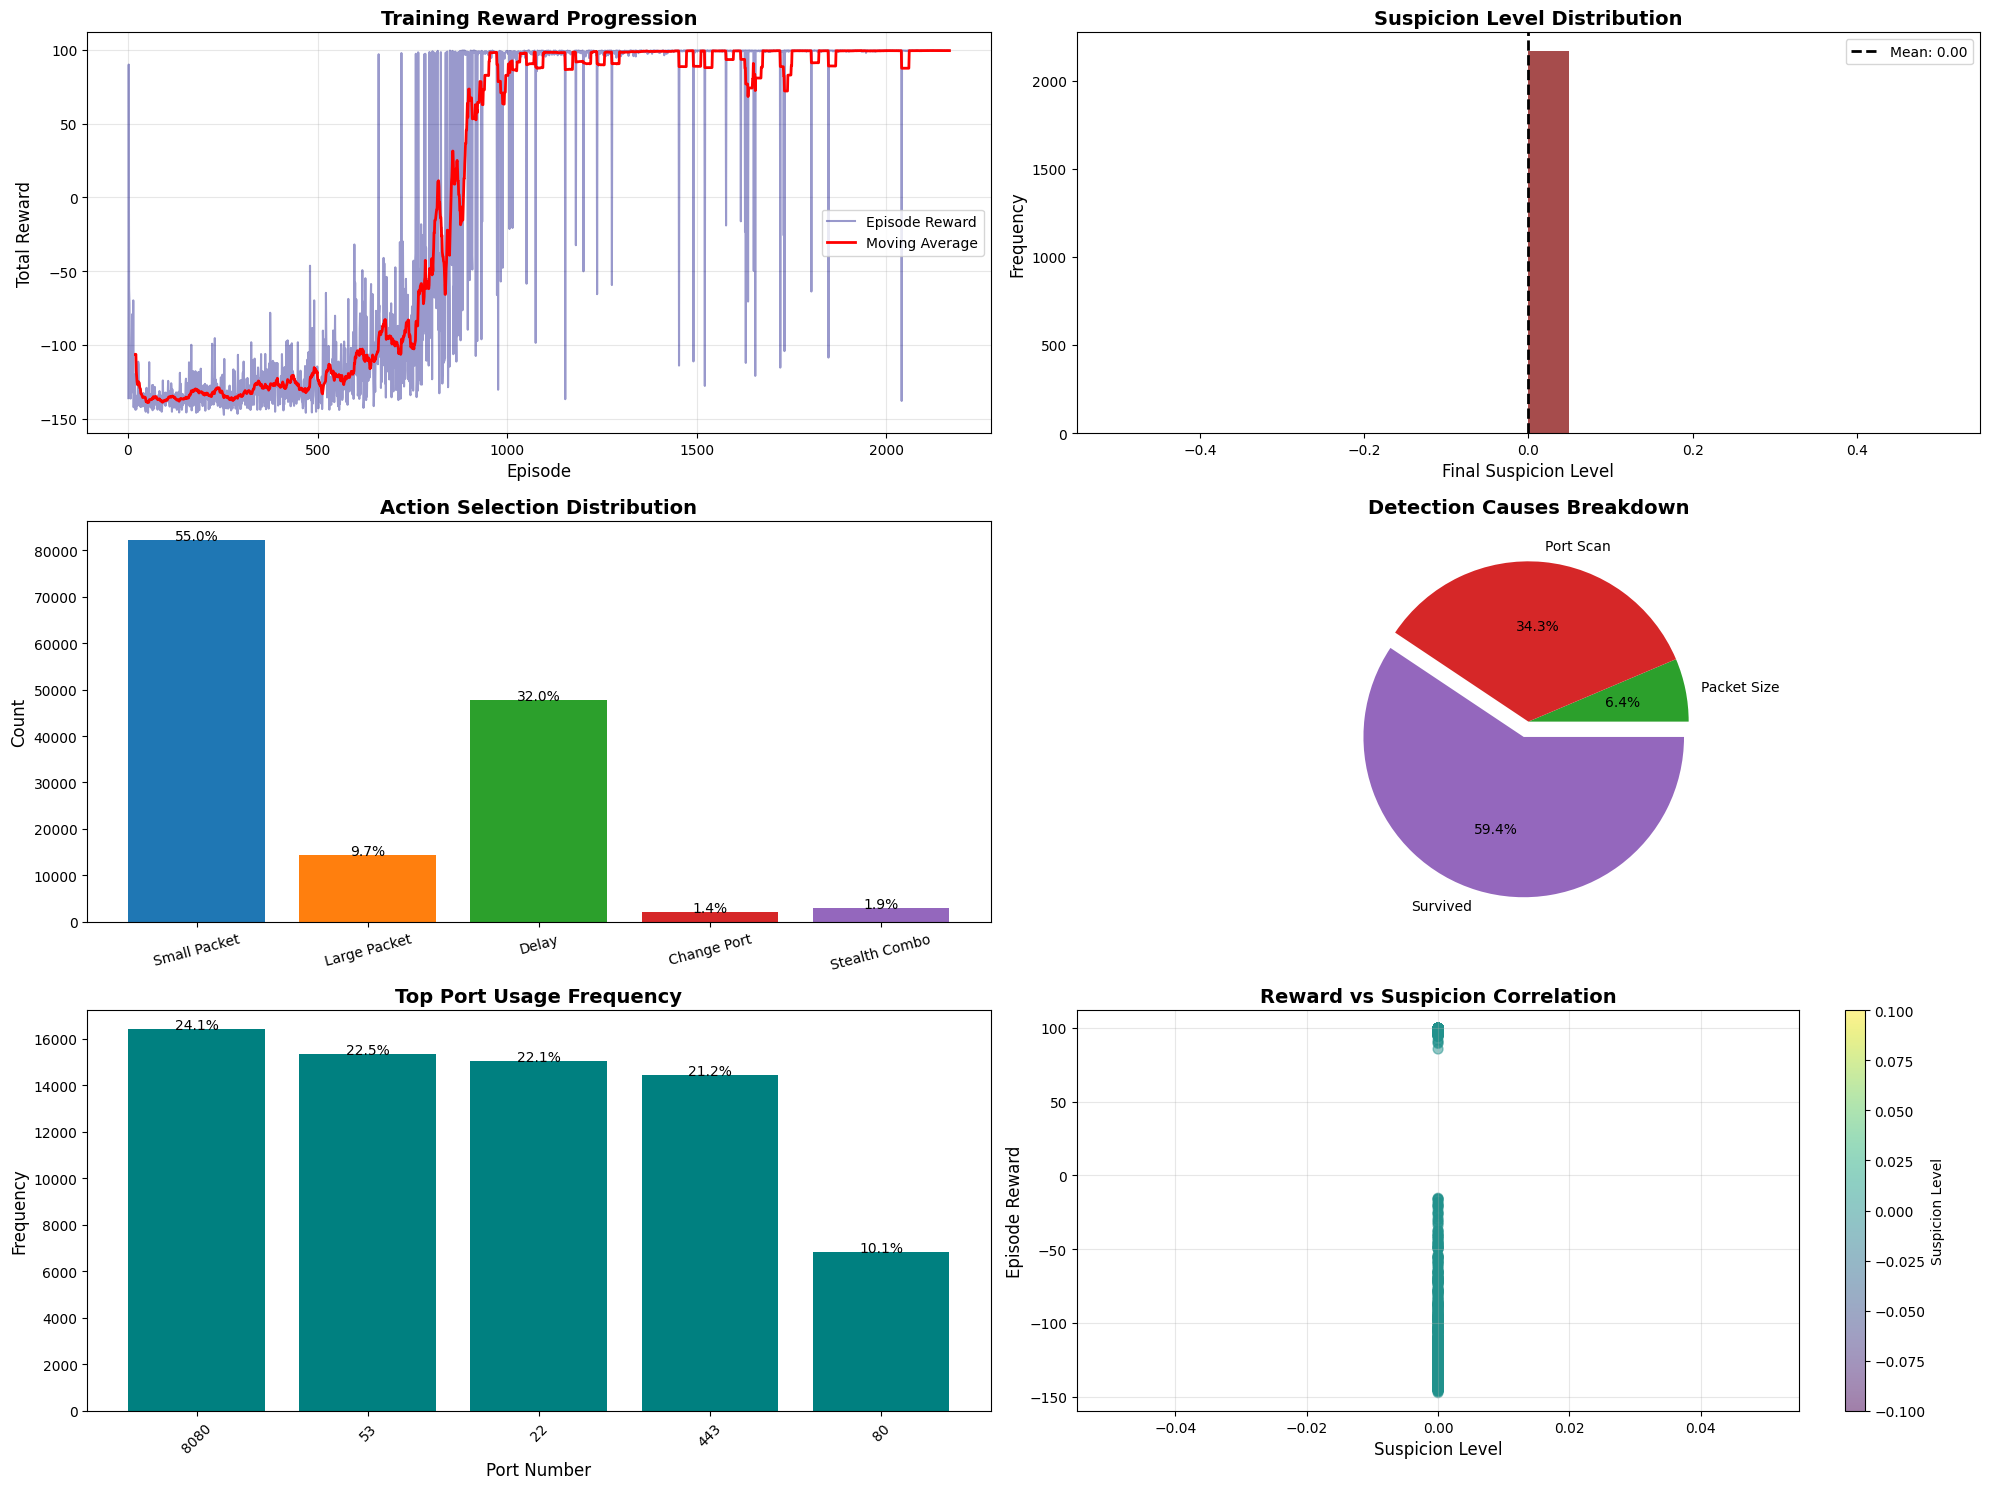

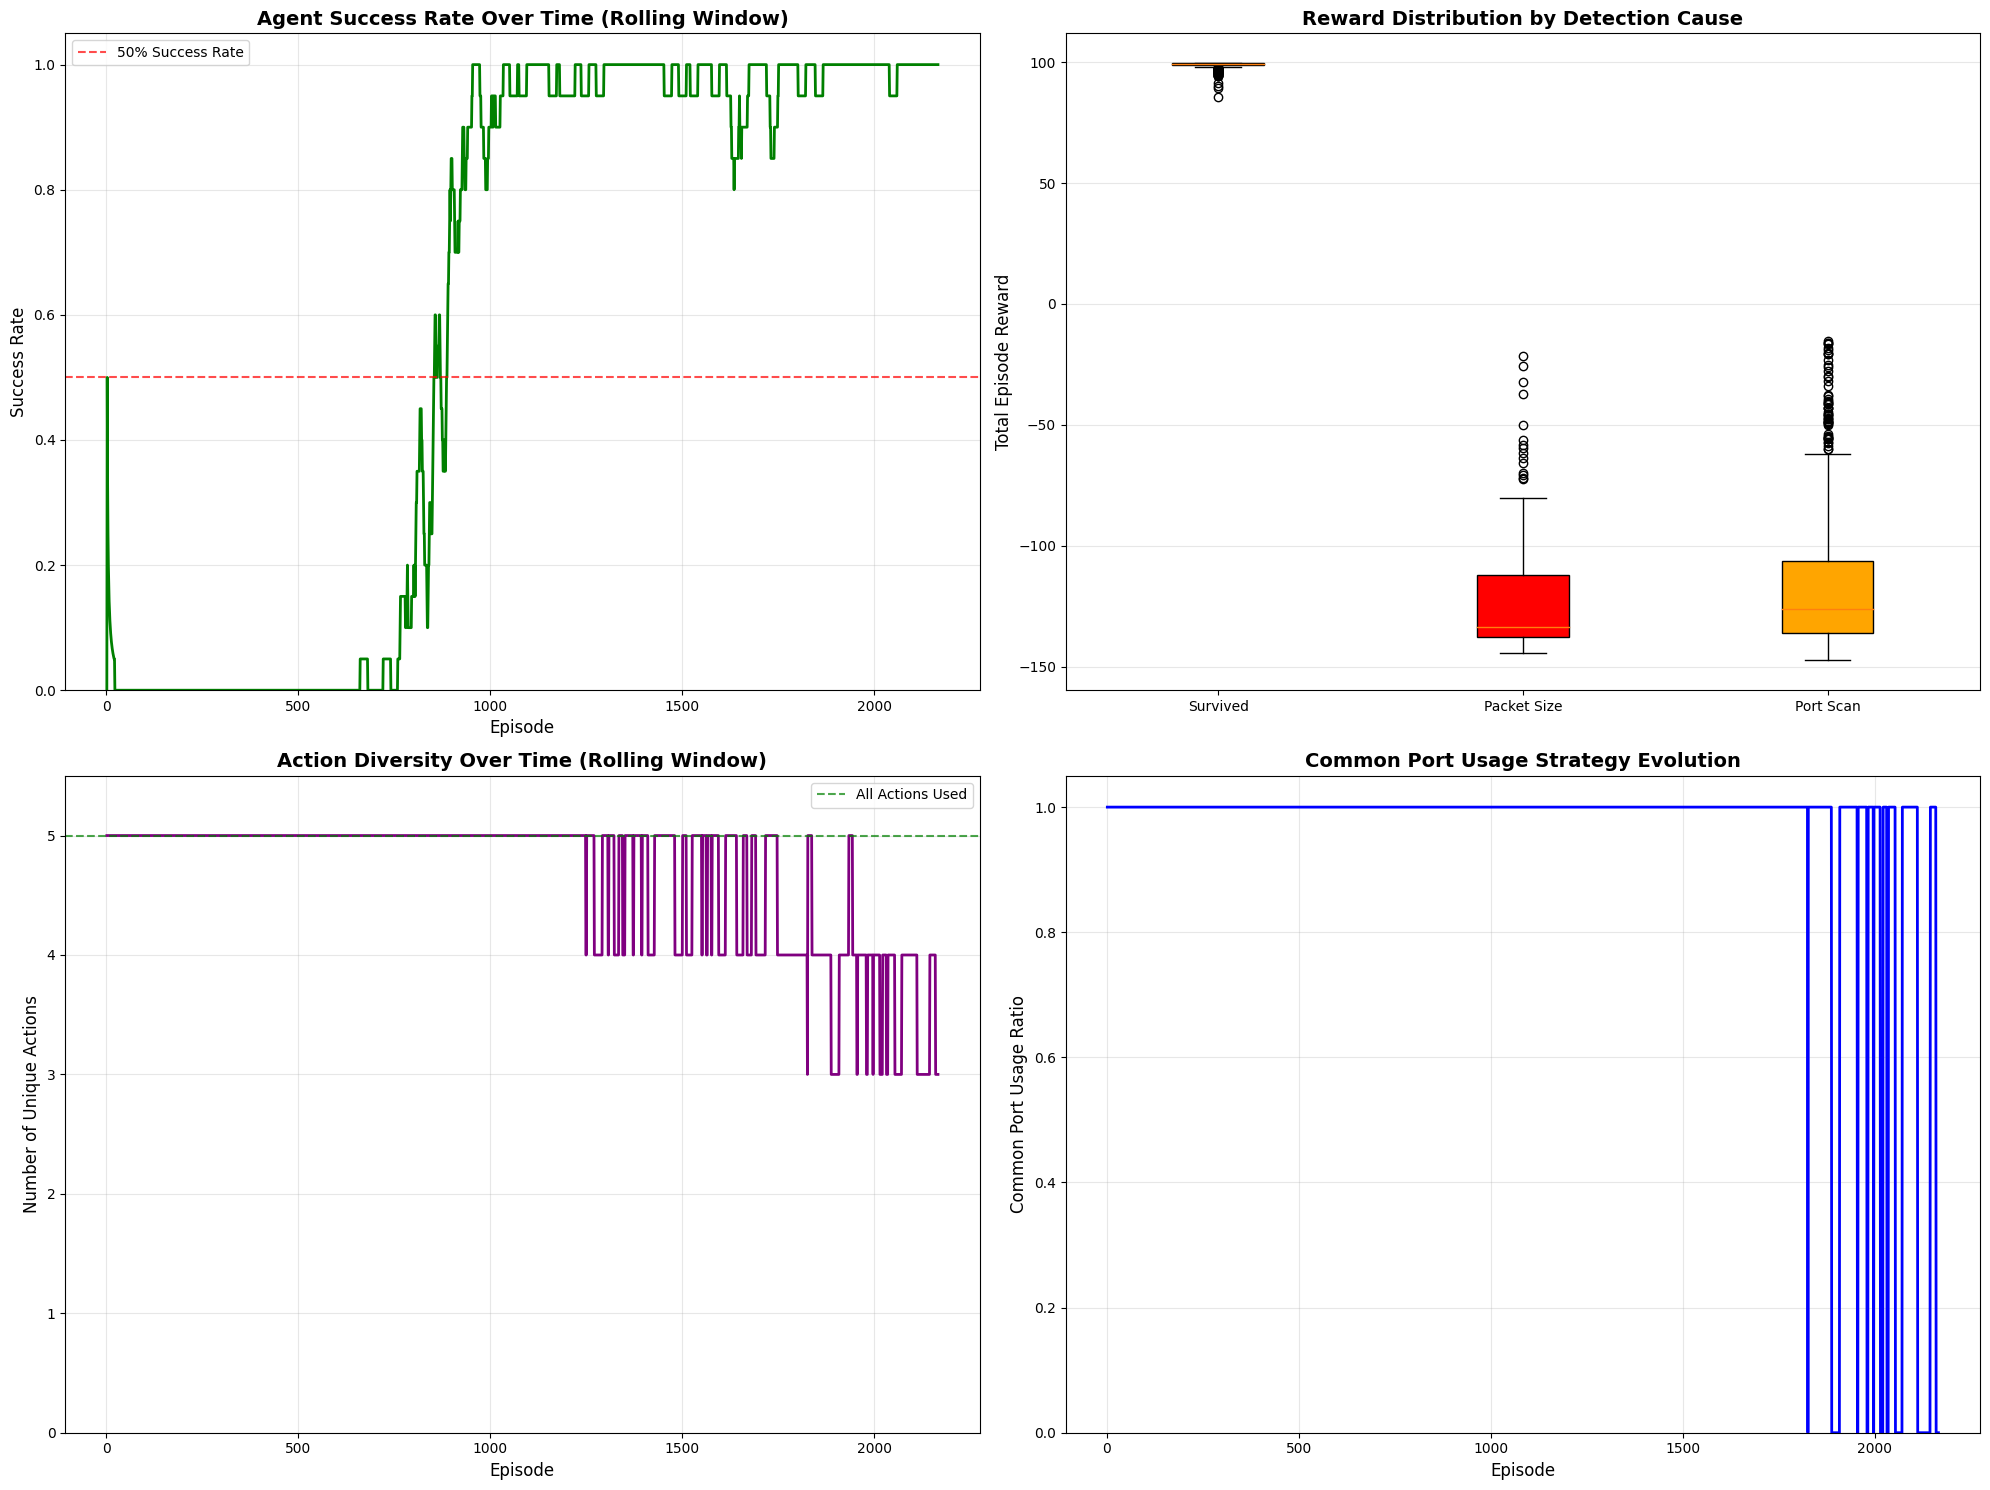

In [9]:
model, training_metrics = run_training(total_timesteps=150000)
plot_training_results(training_metrics)
plot_agent_performance_metrics(training_metrics)


# **Model Evaluation**

In [ ]:
def enhanced_evaluation(model: PPO, num_episodes: int = 20) -> dict:
    env = AdvancedNetworkEnv()
    env.base_detection_probability = 0.6  
    env.base_port_scan_threshold = 2     
    
    results: dict = {
        'rewards': [],
        'detected': [],
        'detection_causes': [],
        'ports_used': [],
        'actions_taken': [],
        'episode_lengths': [],
        'suspicion_levels': []  
    }
    
    for _ in tqdm(range(num_episodes), desc="Evaluating"):
        obs = env.reset()
        done = False
        episode_data = {'reward': 0, 'ports': set(), 'actions': []}
        step_count = 0
        
        while not done:
            
            noisy_obs = obs + np.random.normal(0, 0.02, size=obs.shape)
            action, _ = model.predict(noisy_obs)
            obs, reward, done, info = env.step(action)
            episode_data['reward'] += reward
            episode_data['ports'].add(env.current_port)
            episode_data['actions'].append(action)
            step_count += 1
            
        results['rewards'].append(episode_data['reward'])
        results['detected'].append(1 if info.get('detection_cause') not in ['none', 'survived'] else 0)
        results['detection_causes'].append(info.get('detection_cause', 'none'))
        results['ports_used'].append(len(episode_data['ports']))
        results['actions_taken'].append(episode_data['actions'])
        results['episode_lengths'].append(step_count)
        results['suspicion_levels'].append(env.suspicion_level)
    
    print("\nFinal Evaluation Report:")
    print(f"Average Reward: {np.mean(results['rewards']):.2f} ± {np.std(results['rewards']):.2f}")
    evasion_rate = (1 - sum(results['detected']) / len(results['detected'])) * 100
    print(f"Evasion Rate: {evasion_rate:.1f}%")
    print(f"Average Ports Used: {np.mean(results['ports_used']):.1f}")
    print(f"Average Episode Length: {np.mean(results['episode_lengths']):.1f} steps")
    print(f"Average Suspicion Level: {np.mean(results['suspicion_levels']):.1f}")
    
    
    plot_evaluation_results(results)
    
    return results



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def plot_evaluation_results(results: dict) -> None:
    plt.figure(figsize=(20, 12))
    
    
    plt.subplot(2, 3, 1)
    plt.hist(results['rewards'], bins=10, color='blue', alpha=0.7)
    plt.axvline(np.mean(results['rewards']), color='red', linestyle='dashed', 
               linewidth=2, label=f'Mean: {np.mean(results["rewards"]):.2f}')
    plt.title('Evaluation Reward Distribution', fontsize=14)
    plt.xlabel('Total Episode Reward')
    plt.ylabel('Frequency')
    plt.legend()
    
    
    plt.subplot(2, 3, 2)
    detection_labels = ['Evaded Detection', 'Detected']
    detection_counts = [len(results['detected']) - sum(results['detected']), sum(results['detected'])]
    plt.pie(detection_counts, labels=detection_labels, autopct='%1.1f%%',
            colors=['green', 'red'], explode=[0.1, 0])
    plt.title('Detection Rate', fontsize=14)
    
    
    plt.subplot(2, 3, 3)
    causes = {'Packet Size': 0, 'Port Scan': 0, 'Suspicious Port': 0, 'Survived': 0, 'None': 0}
    for cause in results['detection_causes']:
        if cause == 'packet_size':
            causes['Packet Size'] += 1
        elif cause == 'port_scan':
            causes['Port Scan'] += 1
        elif cause == 'suspicious_port':
            causes['Suspicious Port'] += 1
        elif cause == 'survived':
            causes['Survived'] += 1
        elif cause == 'none':
            causes['None'] += 1
    non_zero_causes = {k: v for k, v in causes.items() if v > 0}
    if non_zero_causes:
        plt.pie(non_zero_causes.values(), labels=non_zero_causes.keys(), autopct='%1.1f%%',
                colors=['#2ca02c', '#d62728', '#9467bd', '#7f7f7f', '#ff7f0e'])
    plt.title('Detection Causes Breakdown', fontsize=14)
    
    
    plt.subplot(2, 3, 4)
    if results['actions_taken']:
        try:
            all_actions = np.concatenate(results['actions_taken'])
            action_counts = np.bincount(all_actions.astype(int), minlength=5)
            action_names = ['Small Packet', 'Large Packet', 'Delay', 'Change Port', 'Stealth Combo']
            plt.bar(action_names, action_counts, 
                    color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
        except Exception as e:
            print(f"Error in action distribution plot: {e}")
    plt.title('Action Selection Distribution', fontsize=14)
    plt.xticks(rotation=15)
    
    
    plt.subplot(2, 3, 5)
    plt.hist(results['episode_lengths'], bins=10, color='purple', alpha=0.7)
    plt.axvline(np.mean(results['episode_lengths']), color='black', linestyle='dashed', 
               linewidth=2, label=f'Mean: {np.mean(results["episode_lengths"]):.2f}')
    plt.title('Episode Length Distribution', fontsize=14)
    plt.xlabel('Steps')
    plt.ylabel('Frequency')
    plt.legend()
    
    
    plt.subplot(2, 3, 6)
    plt.hist(results['ports_used'], bins=range(1, max(results['ports_used'])+2), 
             color='teal', alpha=0.7, rwidth=0.8)
    plt.axvline(np.mean(results['ports_used']), color='red', linestyle='dashed', 
               linewidth=2, label=f'Mean: {np.mean(results["ports_used"]):.2f}')
    plt.title('Unique Ports Used Distribution', fontsize=14)
    plt.xlabel('Number of Unique Ports')
    plt.ylabel('Frequency')
    plt.xticks(range(1, max(results['ports_used'])+1))
    plt.legend()
    
    plt.tight_layout()
    plt.show()



/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/save_util.py:437: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  th_object = th.load(file_content, map_locati


Launching live performance dashboard...


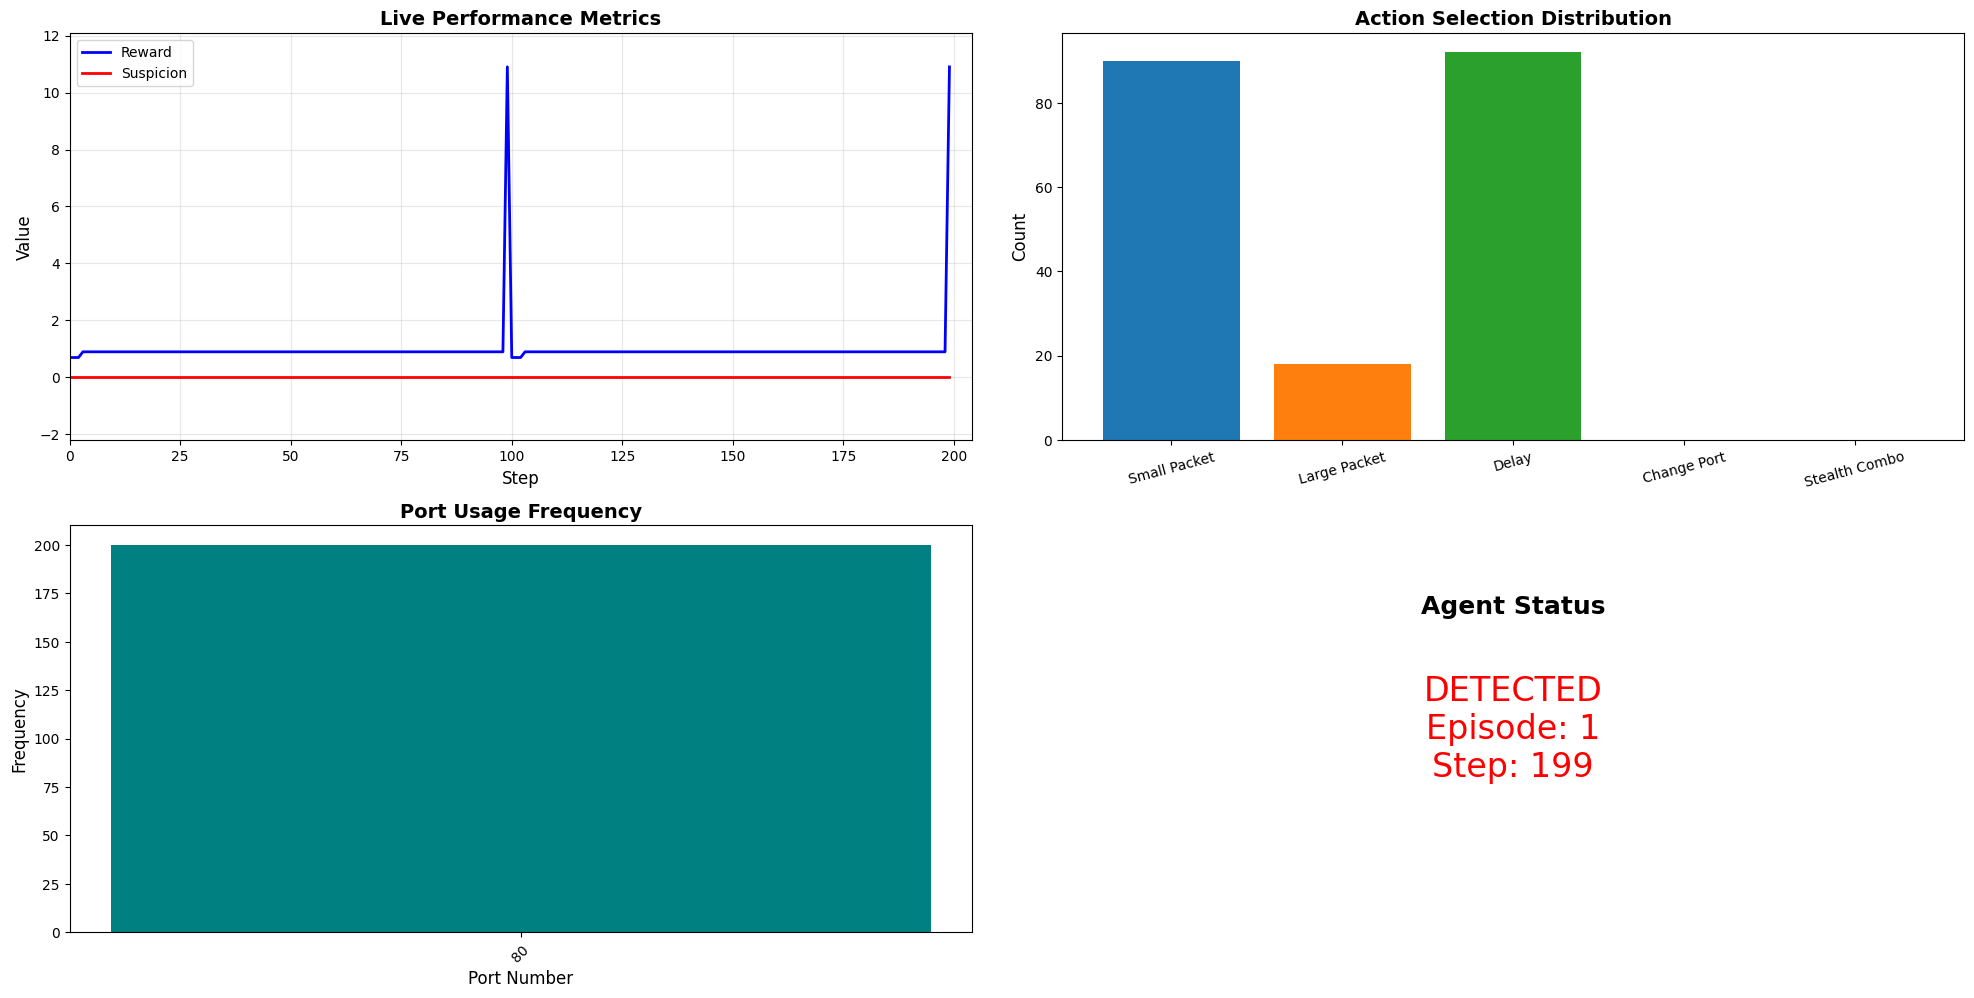


Running final evaluation...


Evaluating: 100%|██████████| 20/20 [00:02<00:00,  9.61it/s]



Final Evaluation Report:
Average Reward: 99.56 ± 0.10
Evasion Rate: 100.0%
Average Ports Used: 1.1
Average Episode Length: 100.0 steps
Average Suspicion Level: 0.0


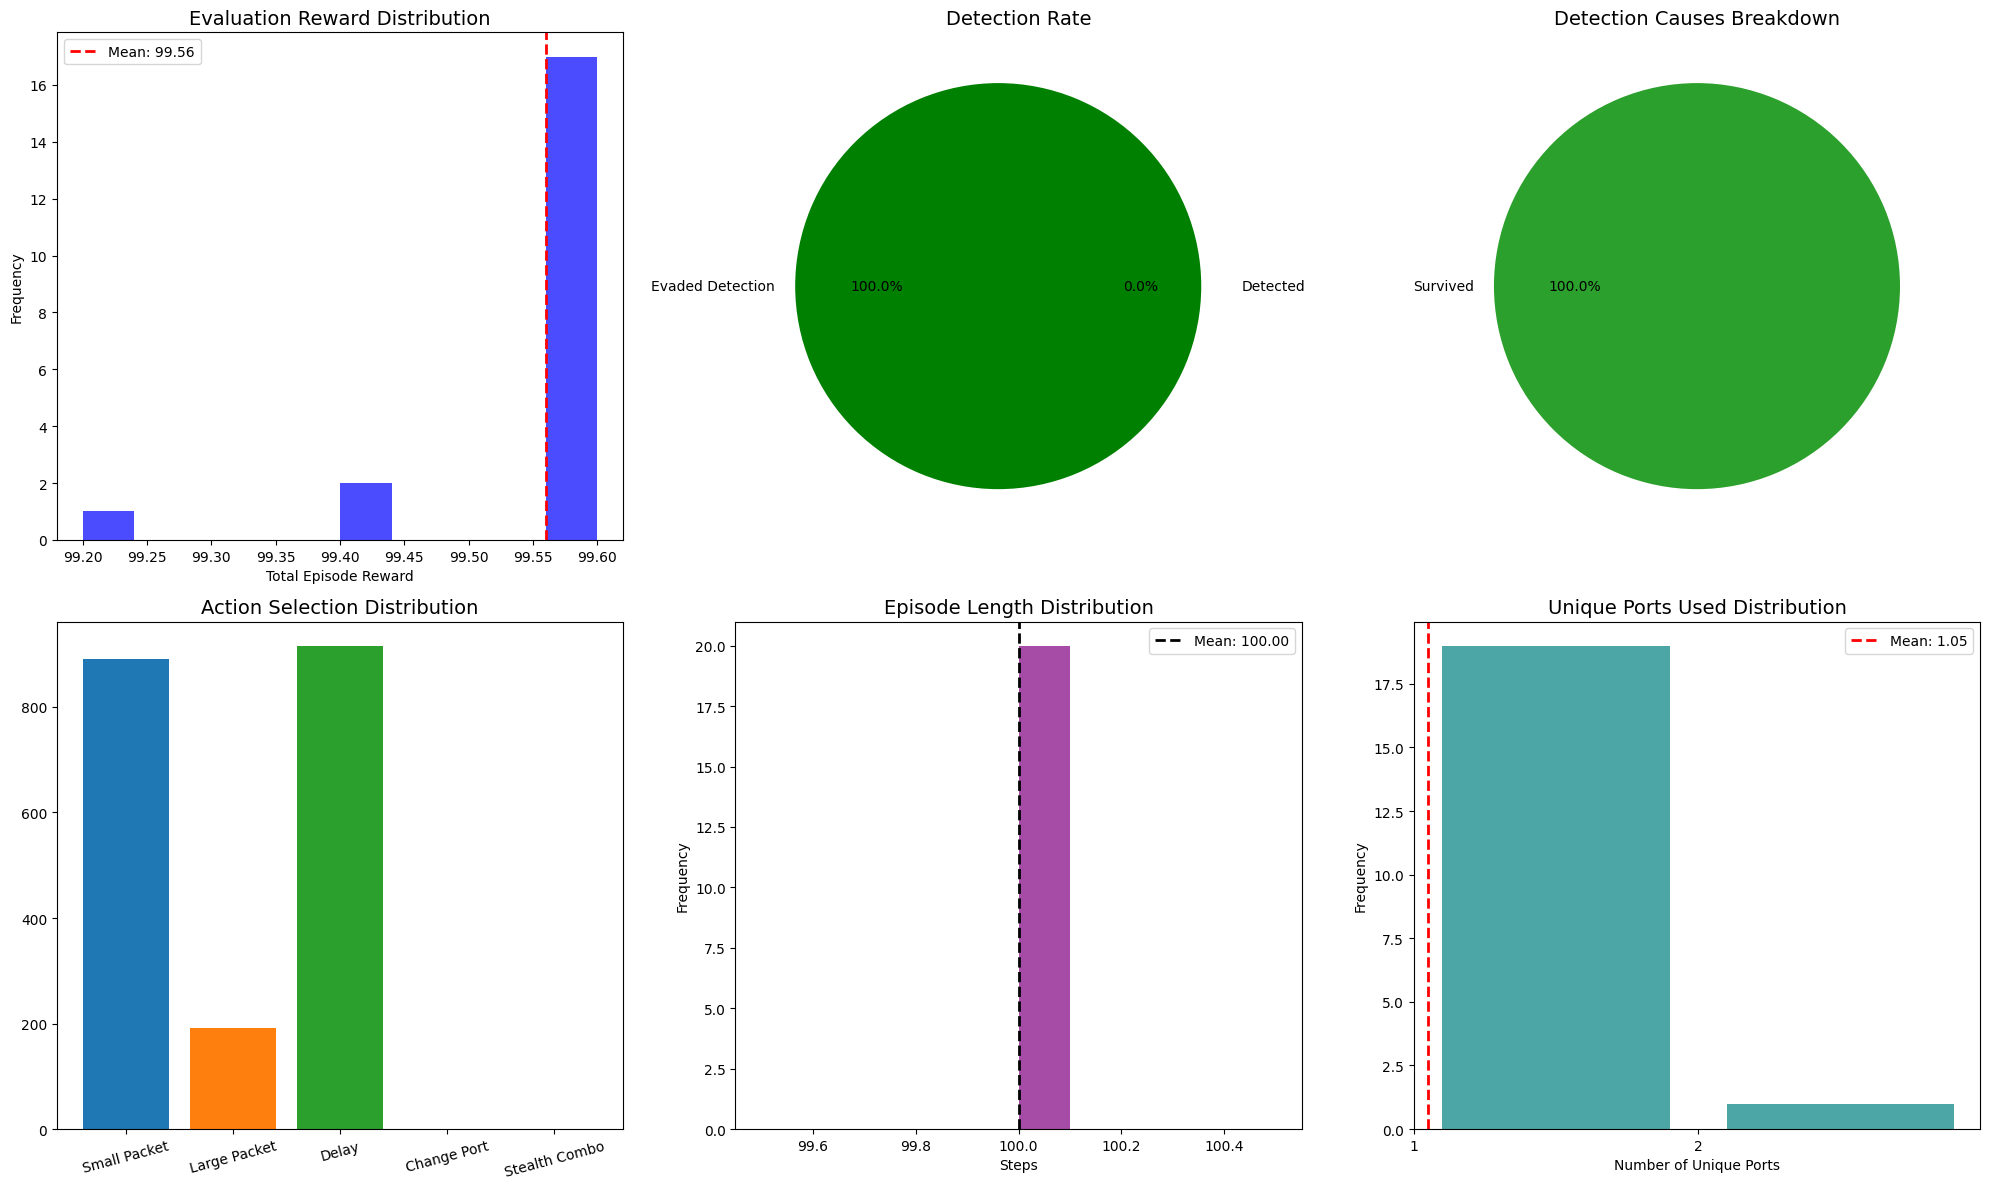

In [12]:
model = PPO.load(MODEL_SAVE_PATH)
print("\nLaunching live performance dashboard...")
dashboard = LiveTrainingDashboard(model)
for step in range(200):
    dashboard.update_dashboard(step)
plt.close()
print("\nRunning final evaluation...")
eval_results = enhanced_evaluation(model, num_episodes=20)
